## Import Libraries

In [97]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any
import json
import warnings

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [98]:
# Paths
DATA_DIR = Path(r"d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data")
OUTPUT_DIR = DATA_DIR / 'ground_truth'

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Input files
EVALUATION_BASE = DATA_DIR / 'evaluation_base.csv'
MANUAL_LABELS = DATA_DIR / 'manual_human_labels.csv'

# Configuration for labeling candidates
MANUAL_ZERO_VULN_SAMPLE_SIZE = 10  # Number of zero-vulnerability workflows to sample
RANDOM_SEED = 42

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nInput files:")
print(f"  Evaluation base: {EVALUATION_BASE}")
print(f"  Manual labels: {MANUAL_LABELS}")
print(f"\nNote: SecurityEval ground truth is extracted from the 'file' column (no external file needed)")

Data directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data
Output directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\ground_truth

Input files:
  Evaluation base: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\evaluation_base.csv
  Manual labels: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\manual_human_labels.csv

Note: SecurityEval ground truth is extracted from the 'file' column (no external file needed)


## 1. Load Data and Ground Truth Files

In [ ]:
# Load evaluation base dataset
df = pd.read_csv(EVALUATION_BASE)

print(f"Evaluation base loaded: {len(df)} workflows")
print(f"\nPrompt type distribution:")
print(df['prompt_type'].value_counts())
print(f"\nColumns: {len(df.columns)}")

# Check for required columns
if 'file' in df.columns:
    securityeval_count = (df['prompt_type'] == 'SecurityEval').sum()
    print(f"\n✓ 'file' column found - can extract expected CWE for {securityeval_count} SecurityEval workflows")
else:
    print(f"\n  Warning: 'file' column not found - cannot extract expected CWE for SecurityEval workflows")

Evaluation base loaded: 84 workflows

Prompt type distribution:
prompt_type
SecurityEval    42
Manual          42
Name: count, dtype: int64

Columns: 36

✓ 'file' column found - can extract expected CWE for 42 SecurityEval workflows


### SecurityEval Ground Truth Strategy

For SecurityEval workflows, the expected CWE is extracted directly from the filename (format: CWE-XXX_author_Y.py). All SecurityEval test cases are known to be vulnerable by design.

In [100]:
# SecurityEval workflows: Extract expected CWE from filename
# No external ground truth file needed - the filename contains the CWE ID

print(f"Processing SecurityEval workflows...")
print(f"Extracting expected CWE from 'file' column (format: CWE-XXX_author_Y.py)")
print(f"\nNote: Ground truth is now derived directly from the filename column.")

Processing SecurityEval workflows...
Extracting expected CWE from 'file' column (format: CWE-XXX_author_Y.py)

Note: Ground truth is now derived directly from the filename column.


### Load Manual Human Labels

In [ ]:
# Load manual human labels if file exists
if MANUAL_LABELS.exists():
    # Try reading with comma delimiter first, then semicolon if that fails
    df_manual_labels = pd.read_csv(MANUAL_LABELS)
    
    # Check if the file was incorrectly parsed (single column with semicolons)
    if len(df_manual_labels.columns) == 1 and ';' in df_manual_labels.columns[0]:
        print("  Detected semicolon delimiter, re-reading CSV...")
        df_manual_labels = pd.read_csv(MANUAL_LABELS, sep=';')
    
    print(f"✓ Manual human labels loaded: {len(df_manual_labels)} records")
    print(f"\nColumns: {list(df_manual_labels.columns)}")
else:
    print(f"  Manual human labels file not found: {MANUAL_LABELS}")

⚠️  Detected semicolon delimiter, re-reading CSV...
✓ Manual human labels loaded: 42 records

Columns: ['workflow_id', 'human_vulnerable', 'human_cwes']


## 2. Create Unified Ground Truth Columns

In [102]:
def parse_cwe_list(cwe_value) -> List[str]:
    """
    Parse CWE list from various formats (string, list, etc.).
    Normalizes all CWE IDs to 'CWE-XXX' format for consistent matching.
    
    Args:
        cwe_value: Value that may be a list, string representation of list, or NaN
        
    Returns:
        List of CWE IDs as strings in 'CWE-XXX' format
    """
    def normalize_cwe_id(cwe_id: str) -> str:
        """Normalize CWE ID to 'CWE-XXX' format."""
        cwe_id = str(cwe_id).strip()
        if not cwe_id:
            return ""
        # If already has CWE- prefix, return as-is
        if cwe_id.upper().startswith('CWE-'):
            return cwe_id.upper()
        # If it's just a number, add CWE- prefix
        if cwe_id.isdigit():
            return f"CWE-{cwe_id}"
        # If it has format like "089" or other number, add prefix
        return f"CWE-{cwe_id}" if cwe_id.replace('-', '').isdigit() else cwe_id.upper()
    
    if pd.isna(cwe_value):
        return []
    
    result = []
    
    if isinstance(cwe_value, list):
        result = [str(cwe) for cwe in cwe_value]
    elif isinstance(cwe_value, str):
        # Try to parse as JSON/list
        try:
            parsed = eval(cwe_value)
            if isinstance(parsed, list):
                result = [str(cwe) for cwe in parsed]
        except:
            pass
        
        if not result:
            # Try to parse as comma-separated
            if ',' in cwe_value:
                result = [cwe.strip() for cwe in cwe_value.split(',') if cwe.strip()]
            # Single value
            elif cwe_value.strip():
                result = [cwe_value.strip()]
    
    # Normalize all CWE IDs to CWE-XXX format
    return [normalize_cwe_id(cwe) for cwe in result if normalize_cwe_id(cwe)]


def normalize_yes_no(value) -> bool:
    """
    Normalize Yes/No values to boolean.
    
    Args:
        value: String value (Yes/No/Y/N) or boolean
        
    Returns:
        Boolean value
    """
    if pd.isna(value):
        return False
    
    if isinstance(value, bool):
        return value
    
    if isinstance(value, str):
        value = value.strip().lower()
        return value in ['yes', 'y', 'true', '1']
    
    return bool(value)


def extract_expected_cwe(filename: str) -> str:
    """
    Extract the expected CWE ID from a SecurityEval filename.
    
    SecurityEval files are formatted as: CWE-XXX_author_Y.py
    This function extracts the CWE-XXX prefix.
    
    Args:
        filename: The filename (e.g., "CWE-089_author_1.py")
        
    Returns:
        CWE ID as string (e.g., "CWE-089"), or empty string if not found
    """
    if pd.isna(filename):
        return ""
    
    filename = str(filename)
    
    # Extract CWE prefix pattern: CWE-XXX
    import re
    match = re.match(r'(CWE-\d+)', filename)
    if match:
        return match.group(1)
    
    return ""


print("Helper functions defined successfully!")


Helper functions defined successfully!


### Merge Ground Truth Data

In [103]:
# Start with base dataset
df_labeled = df.copy()

# Initialize ground truth columns
df_labeled['gt_vulnerable'] = False
df_labeled['gt_cwes'] = [[] for _ in range(len(df_labeled))]
df_labeled['gt_source'] = None  # Track source of ground truth
df_labeled['expected_cwe'] = None  # For SecurityEval: expected CWE from filename

print("Initialized ground truth columns")
print(f"Total workflows: {len(df_labeled)}")

Initialized ground truth columns
Total workflows: 84


### Process SecurityEval Ground Truth

In [ ]:
# Process SecurityEval workflows - extract CWE from filename
securityeval_mask = df_labeled['prompt_type'] == 'SecurityEval'
securityeval_count = securityeval_mask.sum()

print(f"\nProcessing {securityeval_count} SecurityEval workflows...")

# For SecurityEval, extract expected CWE from filename and set ground truth
securityeval_labeled = 0
for idx, row in df_labeled[securityeval_mask].iterrows():
    # Extract expected CWE from the 'file' column
    if 'file' in row.index and pd.notna(row['file']):
        expected_cwe = extract_expected_cwe(row['file'])
        
        if expected_cwe:
            # Set expected CWE for SecurityEval (gt_vulnerable will be set after detection check)
            df_labeled.at[idx, 'gt_cwes'] = [expected_cwe]
            df_labeled.at[idx, 'gt_source'] = 'SecurityEval-ID'
            df_labeled.at[idx, 'expected_cwe'] = expected_cwe  # Add explicit expected_cwe column
            securityeval_labeled += 1

print(f"✓ Applied ground truth to {securityeval_labeled}/{securityeval_count} SecurityEval workflows")
print(f"  (Ground truth extracted from filename - no external file needed)")

if securityeval_labeled < securityeval_count:
    missing = securityeval_count - securityeval_labeled
    print(f"\n Warning: {missing} SecurityEval workflows missing 'file' column or CWE pattern")
    print(f"  Check that the 'file' column exists and follows format: CWE-XXX_author_Y.py")


Processing 42 SecurityEval workflows...
✓ Applied ground truth to 42/42 SecurityEval workflows
  (Ground truth extracted from filename - no external file needed)


In [ ]:
print("\n" + "=" * 80)
print("EXTRACTING DETECTION RESULTS FROM TOOLS (ACROSS ALL ITERATIONS)")
print("=" * 80)

# First, identify all iteration columns
iteration_columns = []
for col in df_labeled.columns:
    if 'iteration_' in col and ('bandit_cwes' in col or 'semgrep_cwes' in col or 'ast_cwes' in col):
        iteration_columns.append(col)

print(f"\nFound {len(iteration_columns)} iteration detection columns")

# Extract detected CWEs from initial detection
detection_columns = {
    'bandit_cwes': 'initial_detection_bandit_cwes',
    'semgrep_cwes': 'initial_detection_semgrep_cwes',
    'ast_cwes': 'initial_detection_ast_cwes'
}

for new_col, source_col in detection_columns.items():
    if source_col in df_labeled.columns:
        df_labeled[new_col] = df_labeled[source_col].apply(parse_cwe_list)
        count = sum(1 for cwes in df_labeled[new_col] if len(cwes) > 0)
        print(f"✓ Extracted {new_col} (initial): {count} workflows with detections")
    else:
        df_labeled[new_col] = [[] for _ in range(len(df_labeled))]
        print(f" Column {source_col} not found - created empty {new_col}")

# Create combined CWE set (union of all tools from initial detection)
df_labeled['combined_cwes'] = df_labeled.apply(
    lambda row: sorted(list(set(
        row.get('bandit_cwes', []) + 
        row.get('semgrep_cwes', []) + 
        row.get('ast_cwes', [])
    ))),
    axis=1
)

combined_count = sum(1 for cwes in df_labeled['combined_cwes'] if len(cwes) > 0)
print(f"✓ Created combined_cwes (initial): {combined_count} workflows with any detections")

# NEW: Create ALL_CWES_ACROSS_WORKFLOW - union of CWEs from all iterations
print(f"\n{'='*80}")
print(f"EXTRACTING ALL CWES ACROSS ENTIRE WORKFLOW (INITIAL + ALL ITERATIONS)")
print(f"{'='*80}")

df_labeled['all_cwes_across_workflow'] = df_labeled.apply(
    lambda row: sorted(list(set(
        # Initial detection
        row.get('bandit_cwes', []) + 
        row.get('semgrep_cwes', []) + 
        row.get('ast_cwes', []) +
        # Add all iteration detections
        [cwe for col in iteration_columns 
         if col in row.index and pd.notna(row[col])
         for cwe in parse_cwe_list(row[col])]
    ))),
    axis=1
)

all_cwes_count = sum(1 for cwes in df_labeled['all_cwes_across_workflow'] if len(cwes) > 0)
print(f"✓ Created all_cwes_across_workflow: {all_cwes_count} workflows with CWEs detected anywhere")

# Statistics
total_initial_cwes = sum(len(cwes) for cwes in df_labeled['combined_cwes'])
total_all_cwes = sum(len(cwes) for cwes in df_labeled['all_cwes_across_workflow'])
print(f"\nCWE Detection Statistics:")
print(f"  Unique CWEs in initial detection: {total_initial_cwes}")
print(f"  Unique CWEs across all workflow: {total_all_cwes}")
print(f"  Additional CWEs from iterations: {total_all_cwes - total_initial_cwes}")

print("\n" + "=" * 80)


EXTRACTING DETECTION RESULTS FROM TOOLS (ACROSS ALL ITERATIONS)

Found 3 iteration detection columns
✓ Extracted bandit_cwes (initial): 84 workflows with detections
✓ Extracted semgrep_cwes (initial): 84 workflows with detections
✓ Extracted ast_cwes (initial): 84 workflows with detections
✓ Created combined_cwes (initial): 84 workflows with any detections

EXTRACTING ALL CWES ACROSS ENTIRE WORKFLOW (INITIAL + ALL ITERATIONS)
✓ Created all_cwes_across_workflow: 84 workflows with CWEs detected anywhere

CWE Detection Statistics:
  Unique CWEs in initial detection: 128
  Unique CWEs across all workflow: 142
  Additional CWEs from iterations: 14



In [ ]:
print("\n" + "=" * 80)
print("TRACKING ADDITIONAL CWES DETECTED")
print("=" * 80)

# Create column for additional CWEs (detected but not expected)
df_labeled['additional_cwes_detected'] = [[] for _ in range(len(df_labeled))]

# Define SecurityEval mask with expected CWE
securityeval_mask = df_labeled['prompt_type'] == 'SecurityEval'
securityeval_with_expected = securityeval_mask & df_labeled['expected_cwe'].notna() & (df_labeled['expected_cwe'] != '')

# For SecurityEval workflows, extract additional CWEs from ENTIRE workflow (not just initial)
for idx, row in df_labeled[securityeval_with_expected].iterrows():
    expected_cwe = row['expected_cwe']
    all_cwes = row.get('all_cwes_across_workflow', [])
    
    # Filter out the expected CWE to get only additional ones
    additional_cwes = [cwe for cwe in all_cwes if cwe != expected_cwe]
    df_labeled.at[idx, 'additional_cwes_detected'] = additional_cwes

# Summary
if securityeval_with_expected.sum() > 0:
    total_additional = sum(len(cwes) for cwes in df_labeled[securityeval_with_expected]['additional_cwes_detected'])
    workflows_with_additional = sum(1 for cwes in df_labeled[securityeval_with_expected]['additional_cwes_detected'] if len(cwes) > 0)
    
    print(f"\nAdditional CWEs detected (beyond expected CWE):")
    print(f"  Total additional CWEs: {total_additional}")
    print(f"  Workflows with additional CWEs: {workflows_with_additional}")
    
    if workflows_with_additional > 0:
        avg_additional = total_additional / workflows_with_additional
        print(f"  Average additional CWEs per workflow (when present): {avg_additional:.2f}")
else:
    print("\n  No SecurityEval workflows with expected CWE found")

print("\n" + "=" * 80)


TRACKING ADDITIONAL CWES DETECTED

Additional CWEs detected (beyond expected CWE):
  Total additional CWEs: 68
  Workflows with additional CWEs: 42
  Average additional CWEs per workflow (when present): 1.62



### Track Additional CWEs Detected

Track CWEs detected beyond the expected CWE. These are analyzed separately and **not** treated as false positives.

In [ ]:
print("\n" + "=" * 80)
print("CREATING MATCH COLUMNS FOR SECURITYEVAL")
print("=" * 80)

# Initialize match columns for INITIAL detection
df_labeled['bandit_matches_expected'] = False
df_labeled['semgrep_matches_expected'] = False
df_labeled['ast_matches_expected'] = False
df_labeled['combined_matches_expected'] = False

# NEW: Match column for ENTIRE WORKFLOW (initial + iterations)
df_labeled['expected_cwe_found_anywhere'] = False

# NEW: Match columns tracking which tool found it across ENTIRE workflow
df_labeled['bandit_found_anywhere'] = False
df_labeled['semgrep_found_anywhere'] = False
df_labeled['ast_found_anywhere'] = False

# For SecurityEval workflows, check if expected CWE is in detected CWEs
securityeval_mask = df_labeled['prompt_type'] == 'SecurityEval'
securityeval_with_expected = securityeval_mask & df_labeled['expected_cwe'].notna() & (df_labeled['expected_cwe'] != '')

# Identify iteration columns for each tool
iteration_columns_by_tool = {
    'bandit': [col for col in df_labeled.columns if 'iteration_' in col and 'bandit_cwes' in col],
    'semgrep': [col for col in df_labeled.columns if 'iteration_' in col and 'semgrep_cwes' in col],
    'ast': [col for col in df_labeled.columns if 'iteration_' in col and 'ast_cwes' in col]
}

for idx, row in df_labeled[securityeval_with_expected].iterrows():
    expected_cwe = row['expected_cwe']
    
    # Check each tool (INITIAL detection only)
    df_labeled.at[idx, 'bandit_matches_expected'] = expected_cwe in row.get('bandit_cwes', [])
    df_labeled.at[idx, 'semgrep_matches_expected'] = expected_cwe in row.get('semgrep_cwes', [])
    df_labeled.at[idx, 'ast_matches_expected'] = expected_cwe in row.get('ast_cwes', [])
    df_labeled.at[idx, 'combined_matches_expected'] = expected_cwe in row.get('combined_cwes', [])
    
    # Check if expected CWE found ANYWHERE in the workflow (initial + all iterations) PER TOOL
    # Bandit - check initial + all iterations
    bandit_found = expected_cwe in row.get('bandit_cwes', [])
    for col in iteration_columns_by_tool['bandit']:
        if col in row.index and pd.notna(row[col]):
            iter_cwes = parse_cwe_list(row[col])
            if expected_cwe in iter_cwes:
                bandit_found = True
                break
    df_labeled.at[idx, 'bandit_found_anywhere'] = bandit_found
    
    # Semgrep - check initial + all iterations
    semgrep_found = expected_cwe in row.get('semgrep_cwes', [])
    for col in iteration_columns_by_tool['semgrep']:
        if col in row.index and pd.notna(row[col]):
            iter_cwes = parse_cwe_list(row[col])
            if expected_cwe in iter_cwes:
                semgrep_found = True
                break
    df_labeled.at[idx, 'semgrep_found_anywhere'] = semgrep_found
    
    # AST - check initial + all iterations
    ast_found = expected_cwe in row.get('ast_cwes', [])
    for col in iteration_columns_by_tool['ast']:
        if col in row.index and pd.notna(row[col]):
            iter_cwes = parse_cwe_list(row[col])
            if expected_cwe in iter_cwes:
                ast_found = True
                break
    df_labeled.at[idx, 'ast_found_anywhere'] = ast_found
    
    # Check if expected CWE found ANYWHERE in the workflow (initial + all iterations)
    df_labeled.at[idx, 'expected_cwe_found_anywhere'] = expected_cwe in row.get('all_cwes_across_workflow', [])
    
    # Set gt_vulnerable based on whether expected CWE was actually detected
    df_labeled.at[idx, 'gt_vulnerable'] = df_labeled.at[idx, 'expected_cwe_found_anywhere']

# Summary
if securityeval_with_expected.sum() > 0:
    print(f"\nMatch statistics for {securityeval_with_expected.sum()} SecurityEval workflows:")
    print(f"\nINITIAL Detection (before any fixes):")
    print(f"  Bandit matched expected CWE: {df_labeled[securityeval_with_expected]['bandit_matches_expected'].sum()}")
    print(f"  Semgrep matched expected CWE: {df_labeled[securityeval_with_expected]['semgrep_matches_expected'].sum()}")
    print(f"  AST matched expected CWE: {df_labeled[securityeval_with_expected]['ast_matches_expected'].sum()}")
    print(f"  Combined matched expected CWE: {df_labeled[securityeval_with_expected]['combined_matches_expected'].sum()}")
    
    found_anywhere = df_labeled[securityeval_with_expected]['expected_cwe_found_anywhere'].sum()
    print(f"\n✓ ENTIRE WORKFLOW (initial + all iterations):")
    print(f"  Expected CWE found at ANY point: {found_anywhere}/{securityeval_with_expected.sum()} ({found_anywhere/securityeval_with_expected.sum()*100:.1f}%)")
    
    # Calculate how many were detected ONLY in iterations (not in initial)
    initial_match = df_labeled[securityeval_with_expected]['combined_matches_expected'].sum()
    only_in_iterations = found_anywhere - initial_match
    print(f"  - Found in initial detection: {initial_match}")
    print(f"  - Found ONLY in iterations: {only_in_iterations}")
else:

    print("\n No SecurityEval workflows with expected CWE found")
    print("\n" + "=" * 80)



CREATING MATCH COLUMNS FOR SECURITYEVAL

Match statistics for 42 SecurityEval workflows:

INITIAL Detection (before any fixes):
  Bandit matched expected CWE: 3
  Semgrep matched expected CWE: 3
  AST matched expected CWE: 3
  Combined matched expected CWE: 7

✓ ENTIRE WORKFLOW (initial + all iterations):
  Expected CWE found at ANY point: 8/42 (19.0%)
  - Found in initial detection: 7
  - Found ONLY in iterations: 1


### Process Manual Ground Truth

For Manual workflows, ground truth comes from human evaluation. We merge with the manual_human_labels.csv file to get the human_vulnerable assessment for each workflow.

In [ ]:
print("\n" + "=" * 80)
print("PROCESSING MANUAL GROUND TRUTH")
print("=" * 80)

# Process Manual workflows - use human labels
manual_mask = df_labeled['prompt_type'] == 'Manual'
manual_count = manual_mask.sum()

print(f"\nProcessing {manual_count} Manual workflows...")

if manual_count > 0 and len(df_manual_labels) > 0:
    # Check if workflow_id exists in manual_labels
    if 'workflow_id' in df_manual_labels.columns:
        # For each Manual workflow, look up its human label
        manual_labeled = 0
        manual_vulnerable = 0
        
        for idx, row in df_labeled[manual_mask].iterrows():
            workflow_id = row['workflow_id']
            
            # Find matching label
            label_row = df_manual_labels[df_manual_labels['workflow_id'] == workflow_id]
            
            if len(label_row) > 0:
                human_vulnerable = label_row.iloc[0]['human_vulnerable']
                is_vulnerable = normalize_yes_no(human_vulnerable)
                
                # Set gt_vulnerable based on human assessment (ONLY for Manual workflows)
                df_labeled.at[idx, 'gt_vulnerable'] = is_vulnerable
                df_labeled.at[idx, 'gt_source'] = 'Manual-Human'
                
                manual_labeled += 1
                if is_vulnerable:
                    manual_vulnerable += 1
        
        print(f"✓ Applied ground truth to {manual_labeled}/{manual_count} Manual workflows")
        print(f"  - Human assessed as vulnerable: {manual_vulnerable}")
        print(f"  - Human assessed as not vulnerable: {manual_labeled - manual_vulnerable}")
        
        if manual_labeled < manual_count:
            missing = manual_count - manual_labeled
            print(f"\n  Warning: {missing} Manual workflows missing human labels")
    else:
        print(f"\n  Warning: 'workflow_id' column not found in manual_human_labels.csv")
        print(f"  Cannot apply ground truth to Manual workflows")
else:
    if manual_count > 0:
        print(f"\n  Warning: Manual human labels file is empty or not loaded")
        print(f"  {manual_count} Manual workflows will have gt_vulnerable=False by default")
    else:
        print(f"\nNo Manual workflows found in dataset")

print("\n" + "=" * 80)


PROCESSING MANUAL GROUND TRUTH

Processing 42 Manual workflows...
✓ Applied ground truth to 42/42 Manual workflows
  - Human assessed as vulnerable: 21
  - Human assessed as not vulnerable: 21



In [109]:
# Summary of Ground Truth Assignment
print("\n" + "=" * 80)
print("GROUND TRUTH SUMMARY")
print("=" * 80)

# Overall statistics
total_workflows = len(df_labeled)
total_vulnerable = df_labeled['gt_vulnerable'].sum()
total_not_vulnerable = total_workflows - total_vulnerable

print(f"\nOverall Ground Truth:")
print(f"  Total workflows: {total_workflows}")
print(f"  Marked as vulnerable: {total_vulnerable} ({total_vulnerable/total_workflows*100:.1f}%)")
print(f"  Marked as not vulnerable: {total_not_vulnerable} ({total_not_vulnerable/total_workflows*100:.1f}%)")

# By dataset type
print(f"\nBy Dataset Type:")
for prompt_type in ['SecurityEval', 'Manual']:
    mask = df_labeled['prompt_type'] == prompt_type
    count = mask.sum()
    if count > 0:
        vulnerable = df_labeled[mask]['gt_vulnerable'].sum()
        print(f"  {prompt_type}:")
        print(f"    Total: {count}")
        print(f"    Vulnerable: {vulnerable} ({vulnerable/count*100:.1f}%)")
        print(f"    Not vulnerable: {count - vulnerable} ({(count-vulnerable)/count*100:.1f}%)")

# By ground truth source
print(f"\nBy Ground Truth Source:")
for source in df_labeled['gt_source'].dropna().unique():
    mask = df_labeled['gt_source'] == source
    count = mask.sum()
    vulnerable = df_labeled[mask]['gt_vulnerable'].sum()
    print(f"  {source}: {count} workflows ({vulnerable} vulnerable)")

print("\n" + "=" * 80)


GROUND TRUTH SUMMARY

Overall Ground Truth:
  Total workflows: 84
  Marked as vulnerable: 29 (34.5%)
  Marked as not vulnerable: 55 (65.5%)

By Dataset Type:
  SecurityEval:
    Total: 42
    Vulnerable: 8 (19.0%)
    Not vulnerable: 34 (81.0%)
  Manual:
    Total: 42
    Vulnerable: 21 (50.0%)
    Not vulnerable: 21 (50.0%)

By Ground Truth Source:
  SecurityEval-ID: 42 workflows (8 vulnerable)
  Manual-Human: 42 workflows (21 vulnerable)



### Process Manual Human Labels

In [ ]:
# Process Manual workflows
manual_mask = df_labeled['prompt_type'] == 'Manual'
manual_count = manual_mask.sum()

print(f"\nProcessing {manual_count} Manual workflows...")

if len(df_manual_labels) > 0 and 'workflow_id' in df_manual_labels.columns:
    # Merge manual labels
    df_labeled = df_labeled.merge(
        df_manual_labels[['workflow_id', 'human_vulnerable', 'human_cwes']],
        on='workflow_id',
        how='left',
        suffixes=('', '_manual')
    )
    
    # Apply manual labels
    for idx, row in df_labeled[manual_mask].iterrows():
        if pd.notna(row.get('human_vulnerable')):
            is_vulnerable = normalize_yes_no(row['human_vulnerable'])
            cwes = parse_cwe_list(row.get('human_cwes', []))
            
            df_labeled.at[idx, 'gt_vulnerable'] = is_vulnerable
            df_labeled.at[idx, 'gt_cwes'] = cwes
            df_labeled.at[idx, 'gt_source'] = 'Human'
    
    # Clean up temporary columns
    for col in ['human_vulnerable', 'human_cwes']:
        if col in df_labeled.columns:
            df_labeled = df_labeled.drop(col, axis=1)
    
    labeled_count = (df_labeled[manual_mask]['gt_source'] == 'Human').sum()
    print(f"✓ Applied ground truth to {labeled_count}/{manual_count} Manual workflows")
else:
    print("  No manual human labels available")


Processing 42 Manual workflows...
✓ Applied ground truth to 42/42 Manual workflows


## 3. Export Labeled Dataset and Labeling Candidates

### Export Evaluation Labeled Dataset

In [111]:
# Convert list columns to string for CSV export
df_export = df_labeled.copy()
list_columns = ['gt_cwes', 'bandit_cwes', 'semgrep_cwes', 'ast_cwes', 'combined_cwes', 'all_cwes_across_workflow', 'additional_cwes_detected']
for col in list_columns:
    if col in df_export.columns:
        df_export[col] = df_export[col].apply(lambda x: json.dumps(x) if isinstance(x, list) else '[]')

# Export labeled dataset
labeled_path = DATA_DIR / 'evaluation_labeled.csv'
df_export.to_csv(labeled_path, index=False)

print(f"✓ Labeled dataset exported to: {labeled_path}")
print(f"  Total records: {len(df_export)}")
print(f"  Labeled records: {df_export['gt_source'].notna().sum()}")

✓ Labeled dataset exported to: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Notebooks\data\evaluation_labeled.csv
  Total records: 84
  Labeled records: 84


In [ ]:
# Refresh SecurityEval subset and sample size
securityeval_df = df_labeled[df_labeled['prompt_type'] == 'SecurityEval'].copy()
total_samples = len(securityeval_df)

if total_samples > 0:
    # Create a detailed DataFrame showing which tool detected which CWE
    # ACROSS ENTIRE WORKFLOW (initial + all iterations)
    cwe_detection_details = []
    
    for idx, row in securityeval_df.iterrows():
        expected = row['expected_cwe']
        
        # Check if expected CWE was found by each tool at ANY point in the workflow
        cwe_detection_details.append({
            'workflow_id': row['workflow_id'],
            'expected_cwe': expected,
            'bandit': 1 if row.get('bandit_found_anywhere', False) else 0,
            'semgrep': 1 if row.get('semgrep_found_anywhere', False) else 0,
            'ast': 1 if row.get('ast_found_anywhere', False) else 0,
            'detected_by_any': 1 if row.get('expected_cwe_found_anywhere', False) else 0
        })
    
    cwe_detection_df = pd.DataFrame(cwe_detection_details)
    
    # Group by CWE and sum detections
    cwe_summary = cwe_detection_df.groupby('expected_cwe').agg({
        'bandit': 'sum',
        'semgrep': 'sum',
        'ast': 'sum',
        'detected_by_any': 'sum',
        'workflow_id': 'count'
    }).rename(columns={'workflow_id': 'total_workflows'})
    
    cwe_summary = cwe_summary.sort_values('detected_by_any', ascending=False)
    
    # Filter to show only CWEs that were detected by at least one tool
    cwe_summary_detected = cwe_summary[cwe_summary['detected_by_any'] > 0]
    
    print("\n" + "=" * 80)
    print("CWE DETECTION SUMMARY BY CWE ID (Detected CWEs Only)")
    print("=" * 80)
    print(cwe_summary_detected.to_string())
else:
    print("\n No SecurityEval data available")


CWE DETECTION SUMMARY BY CWE ID (Detected CWEs Only)
              bandit  semgrep  ast  detected_by_any  total_workflows
expected_cwe                                                        
CWE-326            0        1    0                1                2
CWE-259            1        0    0                1                2
CWE-080            0        0    1                1                1
CWE-732            1        0    0                1                1
CWE-094            0        0    1                1                1
CWE-095            0        1    1                1                1
CWE-319            1        1    0                1                2
CWE-605            1        0    0                1                1


### Table 1: CWE Detection Details by Tool

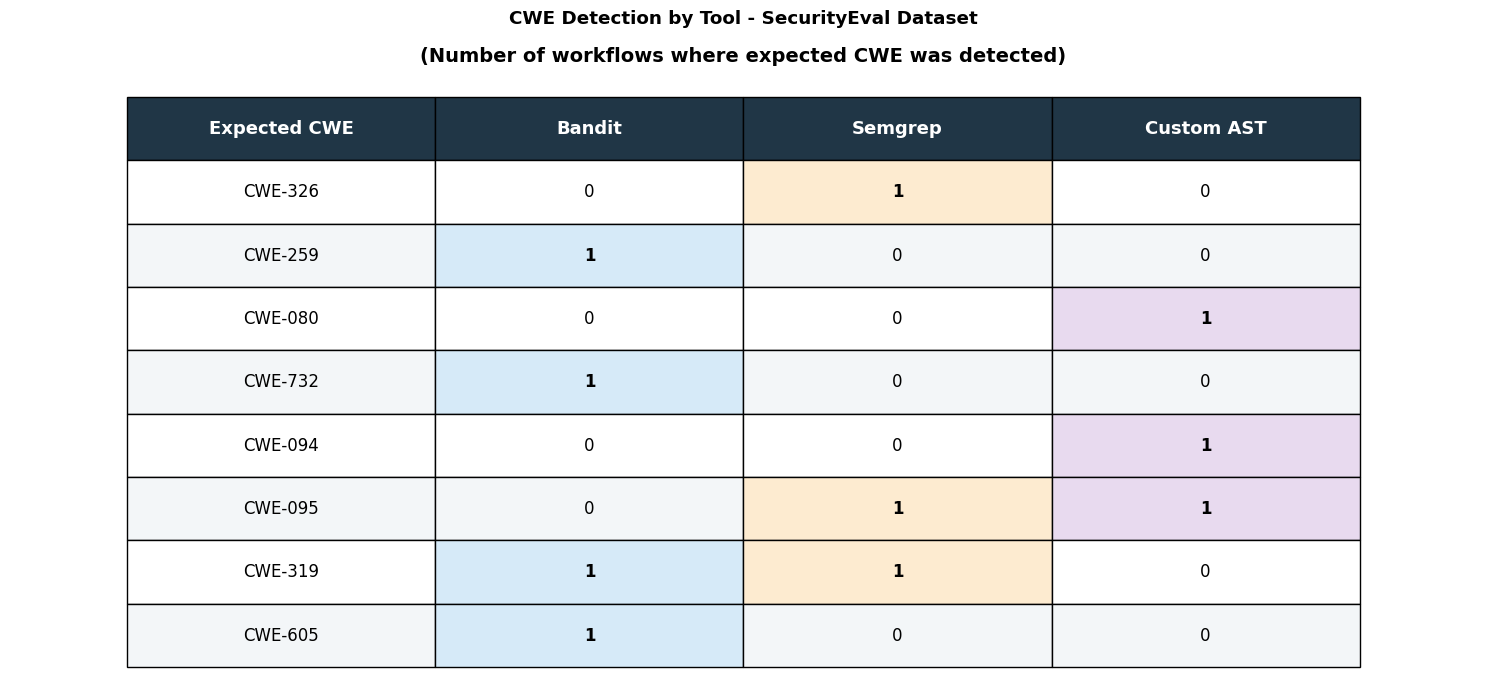

In [ ]:
if total_samples > 0 and 'cwe_summary_detected' in dir():
    # Build data for the figure-only table (no console prints)
    table_data = []
    for cwe in cwe_summary_detected.index:
        row_data = cwe_summary_detected.loc[cwe]
        table_data.append({
            'Expected CWE': cwe,
            'Bandit': int(row_data['bandit']),
            'Semgrep': int(row_data['semgrep']),
            'Custom AST': int(row_data['ast'])
        })
    
    # Create DataFrame for rendering
    table_df = pd.DataFrame(table_data)
    
    # Styled image table matching requested colors/fonts
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 14,
    })
    
    fig, ax = plt.subplots(figsize=(15, max(7, len(table_df) * 0.75)))
    ax.axis('off')
    
    # Build cell text
    table_display_data = []
    for _, row in table_df.iterrows():
        table_display_data.append([
            row['Expected CWE'],
            row['Bandit'],
            row['Semgrep'],
            row['Custom AST']
        ])
    
    col_labels = ['Expected CWE', 'Bandit', 'Semgrep', 'Custom AST']
    mpl_table = ax.table(
        cellText=table_display_data,
        colLabels=col_labels,
        cellLoc='center',
        loc='center',
        bbox=[0.08, 0.02, 0.84, 0.94]
    )
    
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(12)
    mpl_table.scale(1.2, 1.6)
    
    # Colors
    header_bg = '#203646'          # dark slate blue header
    zebra_light = '#f3f6f8'        # light zebra row
    bandit_hi = '#d6eaf8'          # light blue
    semgrep_hi = '#fdebd0'         # light orange
    ast_hi = '#e8daef'             # light purple
    
    # Style header
    for j in range(len(col_labels)):
        cell = mpl_table[(0, j)]
        cell.set_facecolor(header_bg)
        cell.set_text_props(weight='bold', color='white', fontsize=13)
    
    # Style data rows: zebra + per-tool highlights + bold when value > 0
    n_rows = len(table_display_data)
    for i in range(1, n_rows + 1):
        # Zebra row base color
        base_color = zebra_light if i % 2 == 0 else 'white'
        # Expected CWE column
        c_cell = mpl_table[(i, 0)]
        c_cell.set_facecolor(base_color)
        c_cell.set_text_props(fontsize=12)
        
        # Tool columns with highlights
        # Bandit
        b_cell = mpl_table[(i, 1)]
        b_val = table_display_data[i-1][1]
        if b_val > 0:
            b_cell.set_facecolor(bandit_hi)
            b_cell.set_text_props(weight='bold', fontsize=12)
        else:
            b_cell.set_facecolor(base_color)
            b_cell.set_text_props(fontsize=12)
        # Semgrep
        s_cell = mpl_table[(i, 2)]
        s_val = table_display_data[i-1][2]
        if s_val > 0:
            s_cell.set_facecolor(semgrep_hi)
            s_cell.set_text_props(weight='bold', fontsize=12)
        else:
            s_cell.set_facecolor(base_color)
            s_cell.set_text_props(fontsize=12)
        # AST
        a_cell = mpl_table[(i, 3)]
        a_val = table_display_data[i-1][3]
        if a_val > 0:
            a_cell.set_facecolor(ast_hi)
            a_cell.set_text_props(weight='bold', fontsize=12)
        else:
            a_cell.set_facecolor(base_color)
            a_cell.set_text_props(fontsize=12)
    
    # Titles
    plt.suptitle('CWE Detection by Tool - SecurityEval Dataset', fontweight='bold', y=0.98)
    ax.set_title('(Number of workflows where expected CWE was detected)', fontweight='bold', pad=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n No SecurityEval data or CWE detection summary available")

### Table: CWEs Not Detected by Any Tool

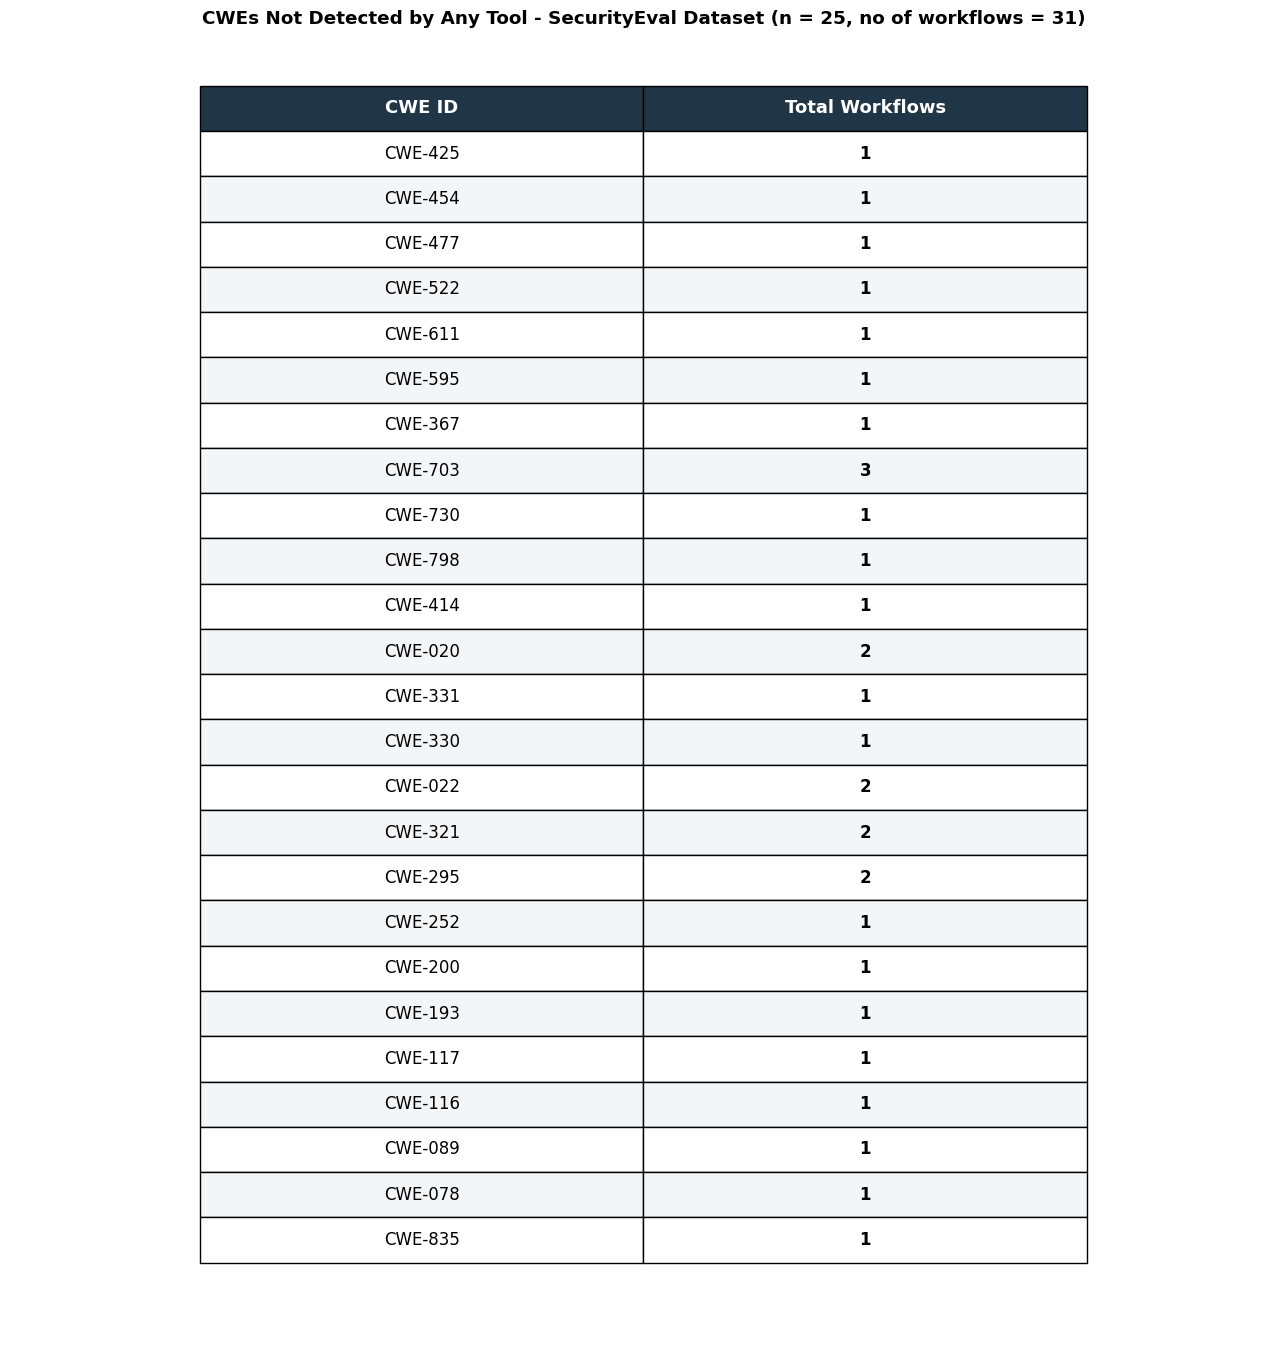

In [ ]:
if total_samples > 0:
    # Filter CWEs that were NOT detected by any tool
    if 'cwe_summary' in dir():
        cwe_failures = cwe_summary[cwe_summary['detected_by_any'] == 0]
    else:
        cwe_failures = pd.DataFrame()
    
    if len(cwe_failures) > 0:
        cwe_count = len(cwe_failures)
        workflow_sum = int(cwe_failures['total_workflows'].sum()) if 'total_workflows' in cwe_failures.columns else 0
        
        # Styled table image only (no console prints)
        import matplotlib.pyplot as plt
        plt.rcParams.update({'font.size': 11, 'axes.titlesize': 14})
        fig, ax = plt.subplots(figsize=(13, max(6, len(cwe_failures) * 0.55)))
        ax.axis('off')
        
        # Prepare table data
        table_data = []
        for cwe, row in cwe_failures.iterrows():
            table_data.append([cwe, int(row['total_workflows'])])
        
        col_labels = ['CWE ID', 'Total Workflows']
        mpl_table = ax.table(
            cellText=table_data,
            colLabels=col_labels,
            cellLoc='center',
            loc='center',
            bbox=[0.15, 0.06, 0.7, 0.9]
        )
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(12)
        mpl_table.scale(1.1, 1.6)
        
        header_bg = '#203646'
        zebra_light = '#f3f6f8'
        
        # Header style
        for j in range(len(col_labels)):
            cell = mpl_table[(0, j)]
            cell.set_facecolor(header_bg)
            cell.set_text_props(weight='bold', color='white', fontsize=13)
        
        # Zebra rows + bold counts
        for i in range(1, len(table_data) + 1):
            base_color = zebra_light if i % 2 == 0 else 'white'
            id_cell = mpl_table[(i, 0)]
            id_cell.set_facecolor(base_color)
            id_cell.set_text_props(fontsize=12)
            cnt_cell = mpl_table[(i, 1)]
            cnt_cell.set_facecolor(base_color)
            cnt_cell.set_text_props(fontsize=12, weight='bold')
        
        title = f'CWEs Not Detected by Any Tool - SecurityEval Dataset (n = {cwe_count}, no of workflows = {workflow_sum})'
        plt.suptitle(title, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
    else:
        print("\n✓ All CWEs were detected by at least one tool!")
else:
    print("\n No SecurityEval data available")